In [1]:
# установка библиотек через jupyter notebook

# !pip install pandas
# !pip install catboost
# !pip install sklearn
# !pip install imblearn

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from IPython.display import display, HTML

# установка отображения количества строк в одной таблице при визуализации
pd.set_option('display.max_rows', 100)

In [3]:
def c_v(est, X, y):
    # кросс-валидация и отображение оценок для тестовой выборки
    #auc_score = cross_val_score(est, X, y, cv=10, scoring='roc_auc')
    #print("cross-validation roc_auc %0.3f ±%0.3f" % (auc_score.mean(), auc_score.std()))
    
    # получение оценок из кроссвалидации с доп. параметрами
    # return_train_score - добавление оценок по обучающей выборке в результат кросс-валидации
    # return_estimator - сохранение обученной модели(классификатора) для каждой валидации
    cv_scores = cross_validate(est, X, y, cv=3, scoring='roc_auc', return_train_score=True, return_estimator=False)
    #print([e.get_all_params() for e in cv_scores['estimator']])
    
    # отображение средней метрики roc auc и стандартного отклонения для обучающей и тестовой выборки
    print("cross-validation roc_auc train→ %0.3f ±%0.3f" % (cv_scores['train_score'].mean(), cv_scores['train_score'].std()))
    print("cross-validation roc_auc test→ %0.3f ±%0.3f" % (cv_scores['test_score'].mean(), cv_scores['test_score'].std()))
    return

def gs_cb_cv(cb_est, X, y):
    # перечисление параметров catboost для поиска по сетке
    parameters = {
#        'depth': [6, 7, 8], #max 16 # глубина дерева
#        'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.5, 1], # a в градиентном бустинге, шаг обучения https://www.kdnuggets.com/2020/05/5-concepts-gradient-descent-cost-function.html
        'l2_leaf_reg': [3, 4, 5], # коэфициент регуляризации lambda def. 3
        'iterations': [1000, 1500, 2000, 2500, 3000], # число итераций обучения
        'verbose': [False] # вкл/выкл подробный отчет о ходе обучения
    }
    
    # вызов поиска параметров по сетке
    grid_search = GridSearchCV(estimator=cb_est, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc', return_train_score=True)
    grid_search.fit(X, y) # применение на переданной в функцию выборке
    
    best_index = grid_search.best_index_ # получение индекса лучшей модели в истории валидаций поиска по сетке
    gs_cv_scores = grid_search.cv_results_ # получение истории валидаций с результатами
    
    # вывод информации о результатах лучшей модели, среднее значение метрики по обучающей выборке и тестовой,
    # и стандартное отклонение
    print("cross-validation roc_auc train→ %0.3f ±%0.3f" % (gs_cv_scores['mean_train_score'][best_index],
                                                            gs_cv_scores['std_train_score'][best_index]))
    print("cross-validation roc_auc test→ %0.3f ±%0.3f" % (gs_cv_scores['mean_test_score'][best_index],
                                                           gs_cv_scores['std_test_score'][best_index]))
    return

def dr_sf(X, pct):
    """функция для получения количества переменных в процентном соотношении к их общему числу в выборке"""
    # получение количества переменных в выборке
    features_count = len(X.columns)
    
    # получение нужного количества переменных в процентном соотношении с округлением
    num_features = round(features_count*(pct/100))
    
    # вывод информации о количестве получившихся признаков и их процентном соотношении к общему в выборке
    print("%s features selected, %s%s of data" % (num_features, pct, "%"))
    return num_features

In [4]:
# чтение данных с отбрасыванием ненужной колонки
data = pd.read_csv("./german_credit_r.csv").drop(columns=['Unnamed: 0'])

# подсчет пустых значений в выборке и отображение их количества
print("empty values count→", data.isnull().sum().sum())

# визуализация прочитанных данных
display(data)

empty values count→ 0


,chk_acct,duration,credit_his,purpose,amount,saving_acct,present_emp,installment_rate,sex,other_debtor,...,property,age,other_install,housing,n_credits,job,n_people,telephone,foreign,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [5]:
# преобразование целевой переменной к виду 0 и 1
data['default'] = data['default'].replace({2:1, 1:0})

# биннинг возрастных значений
# age_bins = [0, 20, 30, 40, 50, 100]
# age_labels = ['<20', '20-30', '30-40', '40-50', '50+']
# data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# создание дополнительной переменной об иностранной принадлоежности человека
#data['is_foreign'] = np.where(data['foreign']=='A201', 1, 0)

# перечисление списка категориальных переменных
catvars = [
    'chk_acct',
    'credit_his',
    'purpose',
    'saving_acct',
    'present_emp',
    'sex',
    'other_debtor',
    'property',
    'other_install',
    'housing',
    'job', 
    'telephone',
    'foreign',
#    "age_group"
    ]

# перечисление списка числовых переменных
numvars = [
    'amount',
    'duration',
    'installment_rate',
    'present_resid',
    'age', 
    'n_credits',
    'n_people',
    'default',
#    'is_foreign'
    ]

Text(0.5, 1.0, 'n_people')

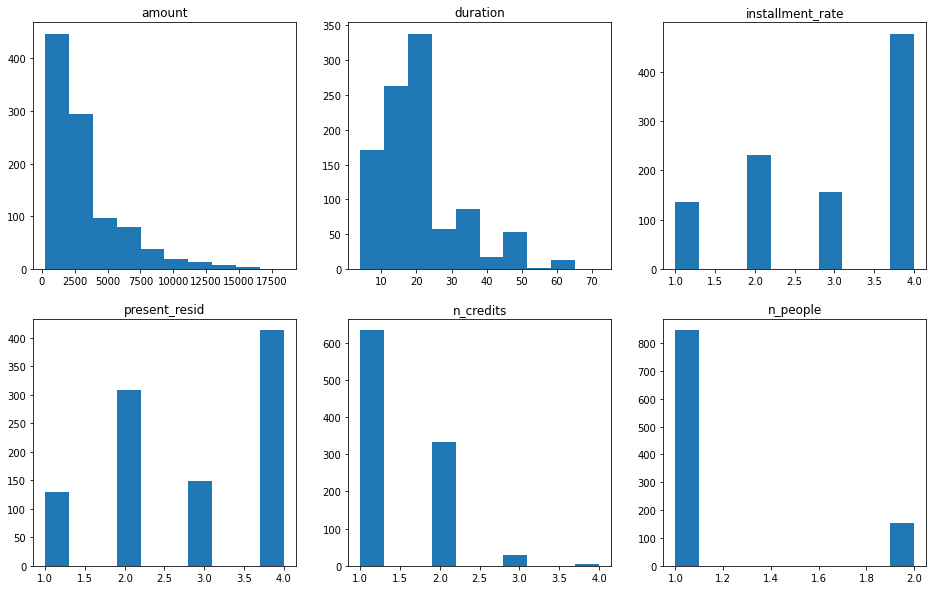

In [6]:
# построение гистограм числовых переменных

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10)) # создание сетки 3х2 для графиков

axes[0, 0].hist(data['amount']) # построение гистограммы суммы кредита
axes[0, 0].set_title('amount') # добавление подписи к графику

axes[0, 1].hist(data['duration'])
axes[0, 1].set_title('duration')

axes[0, 2].hist(data['installment_rate'])
axes[0, 2].set_title('installment_rate')

axes[1, 0].hist(data['present_resid'])
axes[1, 0].set_title('present_resid')

axes[1, 1].hist(data['n_credits'])
axes[1, 1].set_title('n_credits')

axes[1, 2].hist(data['n_people'])
axes[1, 2].set_title('n_people')

### rescaling
- https://feature-engine.readthedocs.io/en/1.2.x/#numerical-transformation-transformers
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Text(0.5, 1.0, 'n_people')

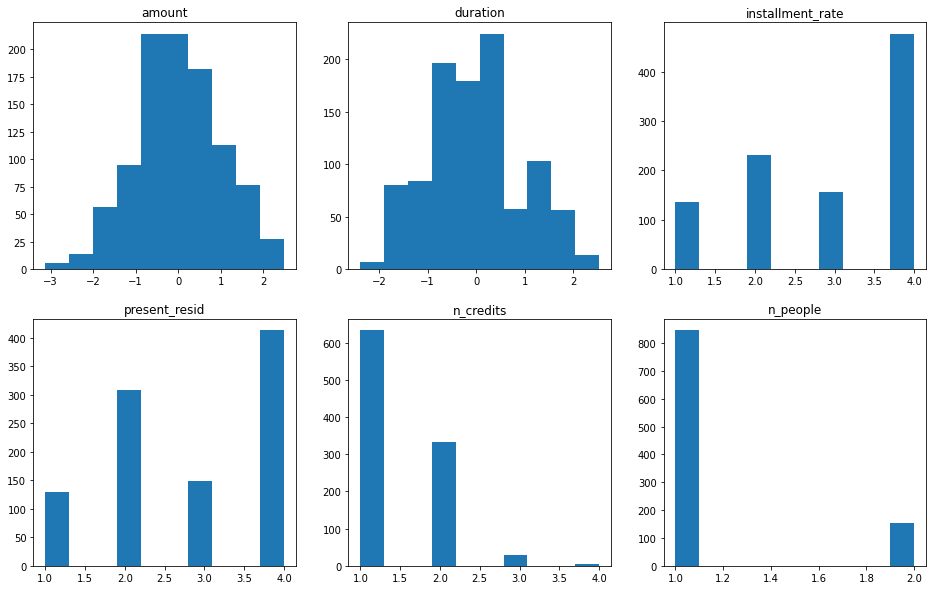

In [7]:
# исправление перекоса в данных для колонок amount и duration сразу с трансформацией
# приведение к виду нормального распределения
# https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
# https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/
data['amount'] = PowerTransformer(method='box-cox').fit_transform(np.array(data['amount']).reshape(-1, 1))
data['duration'] = PowerTransformer(method='yeo-johnson').fit_transform(np.array(data['duration']).reshape(-1, 1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10)) # создание сетки 3х2 для графиков

# отображение графиков после трансформации
axes[0, 0].hist(data['amount'])
axes[0, 0].set_title('amount')

axes[0, 1].hist(data['duration'])
axes[0, 1].set_title('duration')

axes[0, 2].hist(data['installment_rate'])
axes[0, 2].set_title('installment_rate')

axes[1, 0].hist(data['present_resid'])
axes[1, 0].set_title('present_resid')

axes[1, 1].hist(data['n_credits'])
axes[1, 1].set_title('n_credits')

axes[1, 2].hist(data['n_people'])
axes[1, 2].set_title('n_people')

In [8]:
# получение таблицы с нумеричными переменными отдельно от остальных
num_features = data[numvars].drop(['default'], axis=1)

# стандартизация числовых переменных и создание отдельной таблицы для них
num_std = pd.DataFrame(StandardScaler().fit_transform(num_features), columns=num_features.columns)

# трансформация значений методом min max и запись в отдельную таблицу
# https://stackoverflow.com/questions/62178888/can-someone-explain-to-me-how-minmaxscaler-works
num_mm = pd.DataFrame(MinMaxScaler().fit_transform(num_features), columns=num_features.columns)

# кодирование категориальных значений через фиктивные переменные отдельно от остальных
# https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html
# https://towardsdatascience.com/feature-handling-3f14c12ecbb8
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
enc_vars = pd.get_dummies(data[catvars])

# объединение таблицы числовых значений без трансформаций(за исключением приведения к нормальному распределения)
# с закодированными категориальными в новую таблицу чистой выборки
data_pure = pd.concat([data[numvars], enc_vars], axis=1)

# объединение таблицы стандартизированных числовых значений с закодированными категориальными и целевой переменной
data_std = pd.concat([num_std, data['default'], enc_vars], axis=1)

# объединение таблицы min max числовых значений с закодированными категориальными и целевой переменной
data_mm = pd.concat([num_mm, data['default'], enc_vars], axis=1)

# отделение целевой переменной от остальных для каждой выборки, полученной на предыдущих шагах
X_pure = data_pure.drop('default', axis=1)
y_pure = data_pure['default']

X_std = data_std.drop('default', axis=1)
y_std = data_std['default']

X_mm = data_mm.drop('default', axis=1)
y_mm = data_mm['default']

### resampling

target vars before resampling-
0    700
1    300
Name: default, dtype: int64


<AxesSubplot:>

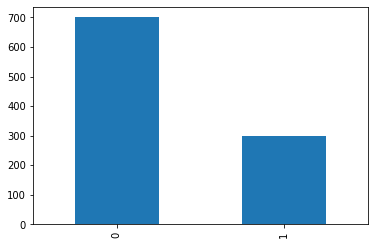

In [9]:
# отображение соотношения классов до алгоритма Synthetic Minority Oversampling Technique

print("target vars before resampling-")
print(y_pure.value_counts()) # расчет количества классов в чистой выборке и отображение
y_pure.value_counts().plot(kind="bar") # построение графика

In [10]:
# применение алгоритма SMOTE на каждой из выборок и создание новых выборок,
# на которых применен алгоритм
# https://vc.ru/ml/129738-algoritm-balansirovki-klassov-smote
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

smt = SMOTE(sampling_strategy='auto') # 'auto' - генерация синтетических примеров для классов, которые в меньшенстве,
                                      # == 'minority' - генерация для класса в меньшенстве.
X_pure_rsmp, y_pure_rsmp = smt.fit_resample(X_pure, y_pure) # применение на чистой выборке
X_std_rsmp, y_std_rsmp = smt.fit_resample(X_std, y_std) # применение на выборке со стандартизированными числовыми переменными
X_mm_rsmp, y_mm_rsmp = smt.fit_resample(X_mm, y_mm) # применение на выборке с min max значениями

target vars after resampling-
0    700
1    700
Name: default, dtype: int64


<AxesSubplot:>

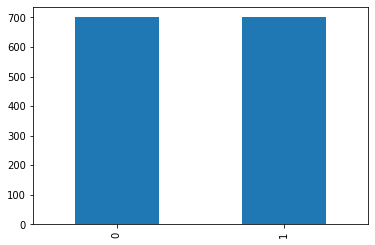

In [11]:
# отображение соотношения классов после алгоритма SMOTE

print("target vars after resampling-")
print(y_pure_rsmp.value_counts())
y_pure_rsmp.value_counts().plot(kind="bar")

### data

In [12]:
# отображение получившихся выборок

print("pure ↓") # чистая выборка
display(X_pure_rsmp)

print("std ↓") # выборка со стандартизированными значениями числовых переменных
display(X_std_rsmp)

print("minmax ↓") # выборка с min max числовыми значениями
display(X_mm_rsmp)

pure ↓


,amount,duration,installment_rate,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_A201,foreign_A202
0,-0.932601,-1.797419,4,4,67,2,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,1.156740,1.764587,2,2,22,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,-0.157834,-0.694530,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,1.496003,1.516606,2,4,45,1,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,0.910973,0.500910,3,4,53,2,2,1,0,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,-0.005831,0.933841,4,4,34,1,1,0,1,0,...,0,1,0,1,0,0,1,0,1,0
1396,-0.309540,0.222882,2,2,25,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1397,0.214422,-0.134650,2,2,24,1,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1398,1.183245,1.750460,4,4,50,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0


std ↓


,amount,duration,installment_rate,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_A201,foreign_A202
0,-0.932601,-1.797419,0.918477,1.046987,2.766456,1.027079,-0.428290,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,1.156740,1.764587,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,-0.157834,-0.694530,-0.870183,0.140505,1.183312,-0.704926,2.334869,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,1.496003,1.516606,-0.870183,1.046987,0.831502,-0.704926,2.334869,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,0.910973,0.500910,0.024147,1.046987,1.535122,1.027079,2.334869,1,0,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.091401,1.496571,0.918477,1.046987,0.249868,-0.704926,-0.428290,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1396,1.454802,1.528608,0.918477,1.046987,0.060644,1.027079,-0.428290,1,0,0,...,0,0,0,0,1,0,0,1,1,0
1397,-1.505437,-0.694530,0.918477,-0.765977,-0.861090,-0.704926,-0.428290,1,0,0,...,1,0,0,0,1,0,1,0,1,0
1398,-1.480601,-0.534433,0.918477,0.019106,-0.235706,-0.704926,-0.428290,1,0,0,...,1,0,0,1,0,0,0,0,1,0


minmax ↓


,amount,duration,installment_rate,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_A201,foreign_A202
0,0.390734,0.119630,1.000000,1.000000,0.857143,0.333333,0.0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,0.763236,0.844359,0.333333,0.333333,0.053571,0.000000,0.0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,0.528864,0.344025,0.333333,0.666667,0.535714,0.000000,1.0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,0.823722,0.793905,0.333333,1.000000,0.464286,0.000000,1.0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,0.719419,0.587250,0.666667,1.000000,0.607143,0.333333,1.0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.831589,0.577437,0.360232,0.333333,0.153665,0.333333,0.0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1396,0.955161,0.855358,0.415093,0.496852,0.251682,0.000000,0.0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
1397,0.584370,0.400580,0.865696,0.666667,0.128727,0.333333,0.0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
1398,0.556203,0.587250,0.909245,0.909245,0.272628,0.242578,0.0,0,1,0,...,1,0,0,0,1,0,0,1,1,0


### feature selection
- https://machinelearningmastery.com/feature-selection-machine-learning-python/
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://feature-engine.readthedocs.io/en/1.2.x/#feature-selection
- https://pypi.org/project/feature-engine/

In [13]:
# применение алгоритма Select K Best на выборке min max, т.к. числовые значения для алгоритма должны быть положительными
# и составление новой выборки, на которой был применен алгоритм
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
skb = SelectKBest(chi2, k=dr_sf(X_mm_rsmp, pct=40)) # выбор переменных в процентном соотношении к их общему количеству
                                                    # через функцию расчета количества в процентном соотношении
                                                    # 'pct=40' = 40% (урезание выборки до 40%)
        # вместо dr_sf(X_mm_rsmp, pct=40) можно указать в k определенное число признаков, которые останутся после урезания.

# применение на выборке min max c ресемплингом
skb.fit(X_mm_rsmp, y_mm_rsmp) # расчет значений перед транформацией
X_mm_rsmp_SKB = skb.transform(X_mm_rsmp) # трансформация выборки min max и сохранение в новую выборку

# отображение топ переменных по статистике хи квадрат
display(pd.DataFrame({
    "f_names":skb.feature_names_in_, # получение списка переменных из алгоритма
    "scores":skb.scores_ # значения статистики пирсона из расчета
    }).sort_values("scores", ascending=False, ignore_index=True)) # сортировка по значению статистики

24 features selected, 40% of data


,f_names,scores
0,chk_acct_A14,186.669065
1,credit_his_A34,83.527950
2,saving_acct_A65,52.020000
3,chk_acct_A11,51.417840
4,property_A121,31.811765
5,purpose_A43,31.149701
6,purpose_A41,30.805310
7,saving_acct_A64,27.000000
8,saving_acct_A63,23.400000
9,present_emp_A74,22.891089


In [14]:
# создание выборки SKB без ресемлинга

skb = SelectKBest(chi2, k=dr_sf(X_mm, pct=80))

skb.fit(X_mm, y_mm)
X_mm_SKB = skb.transform(X_mm)

display(pd.DataFrame({
    "f_names":skb.feature_names_in_, 
    "scores":skb.scores_
    }).sort_values("scores", ascending=False, ignore_index=True))

49 features selected, 80% of data


,f_names,scores
0,chk_acct_A14,63.002659
1,chk_acct_A11,48.450469
2,credit_his_A34,23.344872
3,credit_his_A30,20.119048
4,credit_his_A31,17.190476
5,saving_acct_A65,13.645850
6,property_A124,13.377860
7,chk_acct_A12,10.453001
8,saving_acct_A61,10.291479
9,property_A121,10.218845


In [15]:
# применение алгоритма recursive feature elimination на выборке и составление новых выборок с урезанными переменными
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# https://machinelearningmastery.com/rfe-feature-selection-in-python/

# инициализация алгоритма
rfe = RFE(CatBoostClassifier(verbose=False), n_features_to_select=dr_sf(X_pure_rsmp, pct=75), step=1)

# применение на чистой выборке c rsmp
rfe_fit_pure = rfe.fit(X_pure_rsmp, y_pure_rsmp)
X_pure_rsmp_RFE = rfe.transform(X_pure_rsmp)

# применение на чистой выборке без rsmp
rfe.fit(X_pure, y_pure)
X_pure_RFE = rfe.transform(X_pure)

# применение на выборке со стандартизированными числовыми значениями c rsmp
rfe_fit_std = rfe.fit(X_std_rsmp, y_std_rsmp)
X_std_rsmp_RFE = rfe.transform(X_std_rsmp)

# применение на выборке со стандартизированными числовыми значениями без rsmp
rfe.fit(X_std, y_std)
X_std_RFE = rfe.transform(X_std)

# применение на выборке min max с rsmp
rfe_fit_mm = rfe.fit(X_mm_rsmp, y_mm_rsmp)
X_mm_rsmp_RFE = rfe.transform(X_mm_rsmp)

# применение на выборке min max без rsmp
rfe.fit(X_mm, y_mm)
X_mm_RFE = rfe.transform(X_mm)

# вывод таблицы с признаками, которые были оставлены после применения алгоритма, а какие нет
# f_names - название переменной,
# sel_pure(selected pure) - выбрана ли переменная в чистой выборке
# rank_pure - ранк переменной по важности(меньше - лучше)
display(pd.DataFrame({
    "f_names":rfe_fit_pure.feature_names_in_,
    "sel_pure":rfe_fit_pure.support_,
    "rank_pure":rfe_fit_pure.ranking_,
    "sel_std":rfe_fit_std.support_,
    "rank_std":rfe_fit_std.ranking_,
    "sel_mm":rfe_fit_mm.support_,
    "rank_mm":rfe_fit_mm.ranking_
    }).sort_values(["rank_pure", "rank_std", "rank_mm"], ignore_index=True))

46 features selected, 75% of data


,f_names,sel_pure,rank_pure,sel_std,rank_std,sel_mm,rank_mm
0,amount,True,1,True,1,True,1
1,duration,True,1,True,1,True,1
2,installment_rate,True,1,True,1,True,1
3,present_resid,True,1,True,1,True,1
4,age,True,1,True,1,True,1
5,n_credits,True,1,True,1,True,1
6,n_people,True,1,True,1,True,1
7,chk_acct_A11,True,1,True,1,True,1
8,chk_acct_A12,True,1,True,1,True,1
9,chk_acct_A13,True,1,True,1,True,1


### testing

In [16]:
# получение результатов работы модели градиентного бустинга на разных выборках через кросс-валидацию

print("Gradient Boosting")
gb_classifier = GradientBoostingClassifier(n_estimators=100)

print("\tpure data")
c_v(gb_classifier, X_pure_rsmp, y_pure_rsmp)

print("\tstd data")
c_v(gb_classifier, X_std_rsmp, y_std_rsmp)

print("\tminmax data")
c_v(gb_classifier, X_mm_rsmp, y_mm_rsmp)

print("\tminmax SKB data")
c_v(gb_classifier, X_mm_rsmp_SKB, y_mm_rsmp)

print("\tpure RFE data")
c_v(gb_classifier, X_pure_rsmp_RFE, y_pure_rsmp)

print("\tstd RFE data")
c_v(gb_classifier, X_std_rsmp_RFE, y_std_rsmp)

print("\tminmax RFE data")
c_v(gb_classifier, X_mm_rsmp_RFE, y_mm_rsmp)

Gradient Boosting
	pure data
cross-validation roc_auc train→ 0.983 ±0.009
cross-validation roc_auc test→ 0.908 ±0.064
	std data
cross-validation roc_auc train→ 0.984 ±0.010
cross-validation roc_auc test→ 0.908 ±0.058
	minmax data
cross-validation roc_auc train→ 0.983 ±0.010
cross-validation roc_auc test→ 0.904 ±0.059
	minmax SKB data
cross-validation roc_auc train→ 0.942 ±0.021
cross-validation roc_auc test→ 0.872 ±0.054
	pure RFE data
cross-validation roc_auc train→ 0.982 ±0.010
cross-validation roc_auc test→ 0.911 ±0.064
	std RFE data
cross-validation roc_auc train→ 0.983 ±0.011
cross-validation roc_auc test→ 0.913 ±0.055
	minmax RFE data
cross-validation roc_auc train→ 0.981 ±0.011
cross-validation roc_auc test→ 0.906 ±0.058


In [17]:
# получение результатов работы модели классификатора catboost на разных выборках через кросс-валидацию

print("Catboost")
cb_classifier = CatBoostClassifier(verbose=False)

print("\tpure data")
c_v(cb_classifier, X_pure_rsmp, y_pure_rsmp)
#gs_cb_cv(cb_classifier, X_pure_rsmp, y_pure_rsmp) # получение результатов через подбор параметров модели

print("\tstd data")
c_v(cb_classifier, X_std_rsmp, y_std_rsmp)
#gs_cb_cv(cb_classifier, X_std_rsmp, y_std_rsmp)

print("\tminmax data")
c_v(cb_classifier, X_mm_rsmp, y_mm_rsmp)
#gs_cb_cv(cb_classifier, X_mm_rsmp, y_mm_rsmp)

print("\tminmax SKB data")
c_v(cb_classifier, X_mm_rsmp_SKB, y_mm_rsmp)

print("\tpure RFE data")
c_v(cb_classifier, X_pure_rsmp_RFE, y_pure_rsmp)

print("\tstd RFE data")
c_v(cb_classifier, X_std_rsmp_RFE, y_std_rsmp)

print("\tminmax RFE data")
c_v(cb_classifier, X_mm_rsmp_RFE, y_mm_rsmp)

Catboost
	pure data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.917 ±0.067
	std data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.925 ±0.053
	minmax data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.918 ±0.056
	minmax SKB data
cross-validation roc_auc train→ 0.980 ±0.007
cross-validation roc_auc test→ 0.879 ±0.051
	pure RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.923 ±0.062
	std RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.928 ±0.053
	minmax RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.922 ±0.055


In [18]:
# получение результатов работы модели логистической регрессии на разных выборках через кросс-валидацию

print("Logistic Regression")
lr_classifier = LogisticRegression(max_iter=500)

print("\tpure data")
c_v(lr_classifier, X_pure_rsmp, y_pure_rsmp)
#gs_cb_cv(cb_classifier, X_pure_rsmp, y_pure_rsmp)

print("\tstd data")
c_v(lr_classifier, X_std_rsmp, y_std_rsmp)
#gs_cb_cv(cb_classifier, X_std_rsmp, y_std_rsmp)

print("\tminmax data")
c_v(lr_classifier, X_mm_rsmp, y_mm_rsmp)
#gs_cb_cv(cb_classifier, X_mm_rsmp, y_mm_rsmp)

print("\tminmax SKB data")
c_v(lr_classifier, X_mm_rsmp_SKB, y_mm_rsmp)

print("\tpure RFE data")
c_v(lr_classifier, X_pure_rsmp_RFE, y_pure_rsmp)

print("\tstd RFE data")
c_v(lr_classifier, X_std_rsmp_RFE, y_std_rsmp)

print("\tminmax RFE data")
c_v(lr_classifier, X_mm_rsmp_RFE, y_mm_rsmp)

Logistic Regression
	pure data
cross-validation roc_auc train→ 0.930 ±0.037
cross-validation roc_auc test→ 0.902 ±0.093
	std data
cross-validation roc_auc train→ 0.929 ±0.037
cross-validation roc_auc test→ 0.901 ±0.087
	minmax data
cross-validation roc_auc train→ 0.927 ±0.038
cross-validation roc_auc test→ 0.896 ±0.089
	minmax SKB data
cross-validation roc_auc train→ 0.878 ±0.028
cross-validation roc_auc test→ 0.860 ±0.053
	pure RFE data
cross-validation roc_auc train→ 0.927 ±0.037
cross-validation roc_auc test→ 0.901 ±0.090
	std RFE data
cross-validation roc_auc train→ 0.925 ±0.037
cross-validation roc_auc test→ 0.899 ±0.085
	minmax RFE data
cross-validation roc_auc train→ 0.922 ±0.038
cross-validation roc_auc test→ 0.897 ±0.082


### Test without resampling

In [19]:
print("Gradient Boosting NO RSMP")
gb_classifier = GradientBoostingClassifier(n_estimators=100)

print("\tpure data")
c_v(gb_classifier, X_pure, y_pure)

print("\tstd data")
c_v(gb_classifier, X_std, y_std)

print("\tminmax data")
c_v(gb_classifier, X_mm, y_mm)

print("\tminmax SKB data")
c_v(gb_classifier, X_mm_SKB, y_mm)

print("\tpure RFE data")
c_v(gb_classifier, X_pure_RFE, y_pure)

print("\tstd RFE data")
c_v(gb_classifier, X_std_RFE, y_std)

print("\tminmax RFE data")
c_v(gb_classifier, X_mm_RFE, y_mm)

Gradient Boosting NO RSMP
	pure data
cross-validation roc_auc train→ 0.975 ±0.002
cross-validation roc_auc test→ 0.785 ±0.006
	std data
cross-validation roc_auc train→ 0.975 ±0.002
cross-validation roc_auc test→ 0.785 ±0.005
	minmax data
cross-validation roc_auc train→ 0.975 ±0.002
cross-validation roc_auc test→ 0.784 ±0.006
	minmax SKB data
cross-validation roc_auc train→ 0.971 ±0.001
cross-validation roc_auc test→ 0.788 ±0.006
	pure RFE data
cross-validation roc_auc train→ 0.974 ±0.002
cross-validation roc_auc test→ 0.790 ±0.004
	std RFE data
cross-validation roc_auc train→ 0.974 ±0.002
cross-validation roc_auc test→ 0.790 ±0.004
	minmax RFE data
cross-validation roc_auc train→ 0.974 ±0.002
cross-validation roc_auc test→ 0.790 ±0.004


In [20]:
print("Catboost NO RSMP")
cb_classifier = CatBoostClassifier(verbose=False)

print("\tpure data")
c_v(cb_classifier, X_pure, y_pure)

print("\tstd data")
c_v(cb_classifier, X_std, y_std)

print("\tminmax data")
c_v(cb_classifier, X_mm, y_mm)

print("\tminmax SKB data")
c_v(cb_classifier, X_mm_SKB, y_mm)

print("\tpure RFE data")
c_v(cb_classifier, X_pure_RFE, y_pure)

print("\tstd RFE data")
c_v(cb_classifier, X_std_RFE, y_std)

print("\tminmax RFE data")
c_v(cb_classifier, X_mm_RFE, y_mm)

Catboost NO RSMP
	pure data
cross-validation roc_auc train→ 0.999 ±0.000
cross-validation roc_auc test→ 0.801 ±0.011
	std data
cross-validation roc_auc train→ 0.999 ±0.000
cross-validation roc_auc test→ 0.801 ±0.011
	minmax data
cross-validation roc_auc train→ 0.999 ±0.000
cross-validation roc_auc test→ 0.801 ±0.011
	minmax SKB data
cross-validation roc_auc train→ 0.997 ±0.000
cross-validation roc_auc test→ 0.799 ±0.007
	pure RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.804 ±0.011
	std RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.804 ±0.011
	minmax RFE data
cross-validation roc_auc train→ 0.999 ±0.001
cross-validation roc_auc test→ 0.804 ±0.011


In [21]:
print("Logistic Regression NO RSMP")
lr_classifier = LogisticRegression(max_iter=500)

print("\tpure data")
c_v(lr_classifier, X_pure, y_pure)

print("\tstd data")
c_v(lr_classifier, X_std, y_std)

print("\tminmax data")
c_v(lr_classifier, X_mm, y_mm)

print("\tminmax SKB data")
c_v(lr_classifier, X_mm_SKB, y_mm)

print("\tpure RFE data")
c_v(lr_classifier, X_pure_RFE, y_pure)

print("\tstd RFE data")
c_v(lr_classifier, X_std_RFE, y_std)

print("\tminmax RFE data")
c_v(lr_classifier, X_mm_RFE, y_mm)

Logistic Regression NO RSMP
	pure data
cross-validation roc_auc train→ 0.839 ±0.002
cross-validation roc_auc test→ 0.787 ±0.014
	std data
cross-validation roc_auc train→ 0.839 ±0.002
cross-validation roc_auc test→ 0.787 ±0.013
	minmax data
cross-validation roc_auc train→ 0.838 ±0.002
cross-validation roc_auc test→ 0.787 ±0.012
	minmax SKB data
cross-validation roc_auc train→ 0.836 ±0.002
cross-validation roc_auc test→ 0.793 ±0.011
	pure RFE data
cross-validation roc_auc train→ 0.835 ±0.003
cross-validation roc_auc test→ 0.791 ±0.014
	std RFE data
cross-validation roc_auc train→ 0.835 ±0.003
cross-validation roc_auc test→ 0.790 ±0.014
	minmax RFE data
cross-validation roc_auc train→ 0.835 ±0.003
cross-validation roc_auc test→ 0.791 ±0.013


C:\Program Files\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Cases count: 1400
def lvl-
'train50.82%'
'test48.10%'
Roc auc train: 0.9276816810811711
Roc auc test: 0.9160459623944047
Intercept: 8.002020617933583
Intervals:
[{'bad': 0, 'good': 132, 'interval': Interval(0.0, 0.05, closed='left')},
 {'bad': 9, 'good': 112, 'interval': Interval(0.05, 0.1, closed='left')},
 {'bad': 17, 'good': 71, 'interval': Interval(0.1, 0.15, closed='left')},
 {'bad': 10, 'good': 64, 'interval': Interval(0.15, 0.2, closed='left')},
 {'bad': 11, 'good': 67, 'interval': Interval(0.2, 0.25, closed='left')},
 {'bad': 14, 'good': 46, 'interval': Interval(0.25, 0.3, closed='left')},
 {'bad': 11, 'good': 36, 'interval': Interval(0.3, 0.35, closed='left')},
 {'bad': 14, 'good': 28, 'interval': Interval(0.35, 0.4, closed='left')},
 {'bad': 18, 'good': 26, 'interval': Interval(0.4, 0.45, closed='left')},
 {'bad': 21, 'good': 24, 'interval': Interval(0.45, 0.5, closed='left')},
 {'bad': 19, 'good': 17, 'interval': Interval(0.5, 0.55, closed='left')},
 {'bad': 29, 'good': 24, 

,feature_names,coeficients
0,amount,0.153506
1,duration,0.450609
2,installment_rate,0.187528
3,present_resid,0.061848
4,age,-0.021372
5,n_credits,0.212522
6,n_people,0.178294
7,chk_acct_A11,-0.242409
8,chk_acct_A12,-0.636775
9,chk_acct_A13,-1.194359


,feature_names,iv
0,chk_acct_A14,0.980149
2,credit_his_A34,0.393135
4,saving_acct_A65,0.246300
5,sex_A93,0.184872
6,housing_A152,0.182789
7,property_A121,0.182135
8,purpose_A43,0.171704
9,chk_acct_A11,0.157209
10,present_emp_A74,0.137627
11,purpose_A41,0.127488


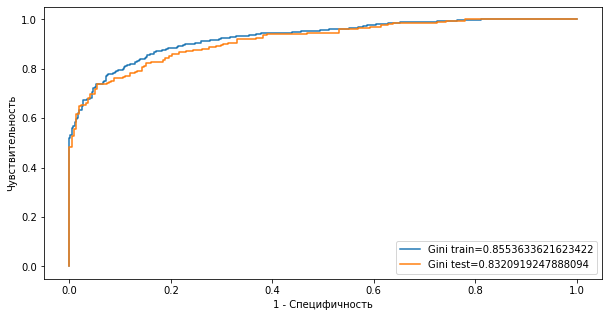

In [22]:
# расчет отчета

from pprint import pprint # библиотека для красивого отображения
from sklearn.metrics import roc_curve, confusion_matrix

#  деление на интервалы
def get_intervals(y, probs, step=0.05):
    # проверка делимости на целое число интервалов
    assert 1 / step - int(1 / step) == 0, "1 / step must be a natural number"

    intervals = list() # создание списка для статистики по интервалам

    # объединение в таблицу правильных ответов и вероятностей модели
    p_df = pd.DataFrame({"y": y, "prob": probs})

    # составление интервалов для автоматического деления
    bins = pd.IntervalIndex.from_tuples([(float("{:.2f}".format(i)), float("{:.2f}".format(i+step))) for i in np.arange(0, 1, step)], closed="left")

    # деление на интервалы
    p_df["interval"] = pd.cut(p_df["prob"], bins=bins, include_lowest=True)

    # расчет кол-ва хороших и плохих в интервале
    for int_ in list(p_df['interval'].value_counts().index): # итерирование по списку интервалов
        int_df = p_df[p_df['interval'] == int_] # получение таблицы содержания интервала(строки, входящие в интервал)
        g_c = int_df['y'].value_counts().get(0, 0) # получение числа хороших для интервала
        b_c = int_df['y'].value_counts().get(1, 0) # получение числа плохих
        intervals.append({"interval":int_, "good": g_c, "bad": b_c}) # добавление статистики по интервалу в общую стати-
                                                                     # стику по интервалам.

    # сортировка интервалов по возрастанию значения вероятности
    intervals.sort(key=lambda x: x['interval'].left)
    return intervals


# получение information value для определенной переменной
# df - выборка, содержащая переменную
# feature - имя переменной
# target - целевые значения y для переменной
# https://gist.github.com/Kirili4ik/1364c8666b042854b35c04b5b82be720
# https://www.youtube.com/watch?v=FaOY5Zy8zAg&ab_channel=AnalyticsUniversity
# https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb
def get_IV(df, feature, target):
    lst = []

    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append([feature,                                                        # Feature name
                    val,                                                            # Value of a feature (unique)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]   # Bad  (1)
                   ])
 
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

    total_bad = df[df[target] == 1].count()[feature]
    total_good = df.shape[0] - total_bad
    
    # расчет WoE
    data['Distribution Good'] = data['Good'] / total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    # расчет IV
    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    iv = data['IV'].sum()

    return iv, data


# переопределение X и y для получения вероятностей по всей выборке
X = X_pure_rsmp
y = y_pure_rsmp

total_data = pd.concat([X, y], axis=1) # объединение X и y в одну целую выборку для расчета iv
iv_dict = dict()
for c in total_data.drop(columns=['default']).columns: # итерация по колонкам общей выборки, кроме колонки с целевыми значениями
    iv_dict[c] = get_IV(total_data, c, 'default')[0] # расчет iv для каждой переменной
# сохранение в таблицу для отображения и сортировка по значению iv
iv_df = pd.DataFrame({"feature_names":iv_dict.keys(), "iv":iv_dict.values()}).sort_values(by="iv",
                                                                                          ascending=False,
                                                                                          ignore_index=True)

# деление выборки на тестовую и обучающую с соотношением 30%/70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# расчет количества примеров в выборке
print("Cases count:", len(y_pure_rsmp))

# расчет уровня дефолтности
print("def lvl-")

# расчет процента дефолтности по выборкам (обучающая, тестовая) и отображение
pprint("train" + "%.2f" % ((y_train.value_counts()[1] / len(y_train))*100) + "%")
pprint("test" + "%.2f" % ((y_test.value_counts()[1] / len(y_test))*100) + "%")

# определение модели логистической регрессии
lr_classifier = LogisticRegression(max_iter=600)

# обучение и получение вероятностей для train, test и общей выборки
lr_classifier.fit(X_train, y_train) # обучение
probabilities_train = lr_classifier.predict_proba(X_train) # вероятности для обучающей
probabilities_test = lr_classifier.predict_proba(X_test) # вероятности для тестовой
probabilities = lr_classifier.predict_proba(X) # вероятности для общей

# расчет roc auc для обучающей и тестовой выборки
print("Roc auc train:", roc_auc_score(y_train, probabilities_train[:,1]))
print("Roc auc test:", roc_auc_score(y_test, probabilities_test[:,1]))

# получение показателя intercept из классификатора логистической регрессии
print("Intercept:", lr_classifier.intercept_[0])

# визуализация посчитанных интервалов с шагом интервала 0.05
print("Intervals:")
pprint(get_intervals(list(y), probabilities[:,1], 0.05))

# отображение коэфициентов логистической регрессии
display(pd.DataFrame({"feature_names": lr_classifier.feature_names_in_, "coeficients": lr_classifier.coef_[0]}))

# отображение значений information value для нечисловых колонок
display(iv_df[~iv_df['feature_names'].isin(numvars)])

# построение графика gini
plt.figure(figsize=(10, 5)) # определение размера графика
plt.ylabel("Чувствительность") # задание подписи для оси y
plt.xlabel("1 - Специфичность") # задание подписи для оси x
fpr, tpr, thresh = roc_curve(y_train, probabilities_train[:,1], pos_label=1) # получение значений для обучающей выборки
                                                                             # false positive
                                                                             # true positive
auc = roc_auc_score(y_train, probabilities_train[:,1]) # расчет auc для обучающей выборки
plt.plot(1-(1-fpr), tpr, label="Gini train=" + str(2*auc-1)) # расчет gini из auc gini=2*auc-1

fpr, tpr, thresh = roc_curve(y_test, probabilities_test[:,1], pos_label=1) # получение значений для тестовой выборки
                                                                           # false positive
                                                                           # true positive
auc = roc_auc_score(y_test, probabilities_test[:,1]) # расчет auc для тестовой выборки
plt.plot(1-(1-fpr), tpr, label="Gini test=" + str(2*auc-1)) # построение графика кривых gini

plt.legend(loc=0) # добавление легенды со значениями gini к графику